# Personlacion de Campaña de Marketing Segmentación de Clientes

En esta tarea, el objetivo es aplicar **Machine Learning** para realizar una segmentación precisa de los **10,000 clientes** previamente seleccionados a través del  algoritmo de recomendación. El enfoque que utilizaremos es el algoritmo **K-Nearest Neighbors (KNN)**, el cual nos permitirá agrupar a los clientes en segmentos bien definidos, basándonos en características demográficas y de comportamiento proporcionadas por el equipo de marketing.

### Variables para la Segmentación

Para la segmentación, se utilizarán las siguientes características clave:

- Edad
- Sexo
- Nivel de ingresos
- Comportamiento y preferencias de compra

### Objetivo de la Segmentación

El objetivo de este análisis es generar **grupos de clientes** que compartan características similares, de modo que el equipo de marketing, liderado por **Erin**, pueda personalizar las creatividades y los mensajes de la campaña de e-mail de manera más efectiva. Al segmentar estos clientes, se espera maximizar la relevancia de las comunicaciones y aumentar las tasas de conversión.

En las próximas secciones se detallará el proceso de implementación del modelo KNN, así como los resultados obtenidos en la generación de estos grupos.




In [85]:
import numpy as np 
import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', 100)
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import RobustScaler,OneHotEncoder
from sklearn.cluster import KMeans

In [86]:
# Leer dataframe con los datos de los 10000 clientes.

df_seleccionados = pd.read_parquet(r'C:\Users\Usuario\Desktop\Nuclio\TFM_Nuclio\easy_money_project\Tarea_3_Recomendación\df_seleccionados.parquet')

El dataset df_seleccionados es el resultado de la Tarea 3 Recomendación. Contiene el pk_cid de los 10.000 clientes a los cuales se les enviarán un email, la recomendación, precio del producto a recomendar , el cluster al que pertence y probabilidad de la compra. Partiremos de este dataset para construir el dataset de la segmentación para la personalización.

In [87]:
df_seleccionados

,pk_cid,recomendacion,prob_compra,precio,beneficio,cluster
226680,1119834,[credit_card],0.987,60,59.212,4
226681,88904,[credit_card],0.987,60,59.191,4
226682,1136278,[credit_card],0.985,60,59.100,4
226686,1119669,[credit_card],0.985,60,59.095,4
226685,1109597,[credit_card],0.985,60,59.095,4
...,...,...,...,...,...,...
229484,1304214,[emc_account],0.955,10,9.553,4
229483,1393343,[payroll_account],0.955,10,9.553,4
229482,1334243,[debit_card],0.955,10,9.553,4
229480,1376649,[emc_account],0.955,10,9.553,4


In [88]:
df_seleccionados['recomendacion'].value_counts()

recomendacion
[debit_card]            3756
[credit_card]           3281
[payroll_account]       1026
[em_acount]              721
[pension_plan]           402
[long_term_deposit]      402
[emc_account]            303
[payroll]                 49
[securities]              28
[short_term_deposit]      22
[funds]                   10
Name: count, dtype: int64

In [89]:
df_seleccionados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 226680 to 229479
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pk_cid         10000 non-null  int64  
 1   recomendacion  10000 non-null  object 
 2   prob_compra    10000 non-null  float32
 3   precio         10000 non-null  int64  
 4   beneficio      10000 non-null  float64
 5   cluster        10000 non-null  int64  
dtypes: float32(1), float64(1), int64(3), object(1)
memory usage: 507.8+ KB


Transformar la columna recomendacion a tipo string y luego category, ya que parece que alguna fila era de tipo lista, asi evitamos futuros problemas.

In [90]:
df_seleccionados['recomendacion'] = df_seleccionados['recomendacion'].astype(str).astype('category')


In [91]:
df_seleccionados.duplicated().sum()

0

In [92]:
# Cargando los datos directamente de s3 de AWS
df_full_cleaned = pd.read_parquet("https://easy-money-project-bucket.s3.eu-west-3.amazonaws.com/df_full_cleaned.parquet")
# sociodemografico
sdg_df_cleaned = pd.read_parquet('https://easy-money-project-bucket.s3.eu-west-3.amazonaws.com/sociodemographic_df_adrian.parquet')


df_full_clean = df_full_cleaned.copy()
# se mergea la edad que faltaba en el df_full_cleaned 
df_full_clean = df_full_clean.merge(sdg_df_cleaned[["pk_cid", "pk_partition", "age"]], on=["pk_cid", "pk_partition"], how="inner")

In [93]:
df_full_clean


,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,country_id,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_date,entry_channel,active_customer,segment,categoria_antiguedad,age
0,1375586,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,1,January,Adultos jóvenes,"87,218.100",Málaga,2018-01-12,Otros,1,02 - PARTICULARES,1-2 años,35
1,1050611,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,1,January,Jóvenes,"35,548.740",Ciudad Real,2015-08-10,KHE,0,03 - UNIVERSITARIO,Más de 3 años,23
2,1050612,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,1,January,Jóvenes,"122,179.110",Ciudad Real,2015-08-10,KHE,0,03 - UNIVERSITARIO,Más de 3 años,23
3,1050613,2018-01-28,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,40,0,ES,H,1,January,Jóvenes,"119,775.540",Zaragoza,2015-08-10,KHD,0,03 - UNIVERSITARIO,Más de 3 años,22
4,1050614,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,1,January,Jóvenes,"101,469.135",Zaragoza,2015-08-10,KHE,1,03 - UNIVERSITARIO,Más de 3 años,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962919,1166765,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Jóvenes,"43,912.170",Zaragoza,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años,22
5962920,1166764,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Jóvenes,"23,334.990","Rioja, La",2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años,23
5962921,1166763,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,5,May,Adultos,"87,930.930",Zaragoza,2016-08-14,KHE,1,02 - PARTICULARES,2-3 años,47
5962922,1166789,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,5,May,Jóvenes,"199,592.820",Zaragoza,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años,22


Obtener el ultimo dato de cada cliente, para combinar con el dataframe de los seleccionados.

In [94]:
# Obtener el índice de la última partición para cada pk_cid
idx = df_full_clean.groupby('pk_cid')['pk_partition'].idxmax()

# Filtrar el DataFrame con las últimas particiones
df_full_clean_last = df_full_clean.loc[idx]

In [95]:
df_full_clean_last

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,country_id,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_date,entry_channel,active_customer,segment,categoria_antiguedad,age
2168122,15891,2018-08-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,H,8,August,Adultos mayores,"117,380.925",Madrid,2018-07-28,KAT,0,02 - PARTICULARES,0-3 meses,59
5523397,16063,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,H,5,May,Adultos mayores,"132,384.450",Madrid,2018-11-19,KAT,0,02 - PARTICULARES,6-9 meses,62
5523396,16203,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Ancianos,"153,902.880",Barcelona,2018-12-23,KAT,1,01 - TOP,3-6 meses,70
5523395,16502,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,2,1,2,0,0,0,0,20,0,0,ES,H,5,May,Adultos mayores,"132,384.450",Madrid,2018-09-30,KHN,1,02 - PARTICULARES,6-9 meses,58
5523398,17457,2019-05-28,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,3,1,2,1,1,0,0,20,40,0,ES,H,5,May,Adultos,"102,405.750",Madrid,2017-09-16,KAT,1,02 - PARTICULARES,1-2 años,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5679916,1553685,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,V,5,May,Adultos,"114,633.765",Ciudad Real,2019-05-31,Otros,0,03 - UNIVERSITARIO,0-3 meses,52
5679915,1553686,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,H,5,May,Adultos jóvenes,"85,787.220",Sevilla,2019-05-31,Otros,0,03 - UNIVERSITARIO,0-3 meses,30
5679914,1553687,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,V,5,May,Jóvenes,"143,419.770",Madrid,2019-05-31,Otros,0,03 - UNIVERSITARIO,0-3 meses,21
5679913,1553688,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,H,5,May,Adultos,"114,633.765",Cantabria,2019-05-31,Otros,0,03 - UNIVERSITARIO,0-3 meses,43


In [96]:
df_full_clean_last['pk_cid'].duplicated().sum()

0

In [97]:
# Hacer el left join
df_joined = df_seleccionados.merge(df_full_clean_last, on='pk_cid', how='left')

# Mostrar el resultado
df_joined

,pk_cid,recomendacion,prob_compra,precio,beneficio,cluster,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,country_id,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_date,entry_channel,active_customer,segment,categoria_antiguedad,age
0,1119834,['credit_card'],0.987,60,59.212,4,2019-05-28,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,3,1,3,0,0,0,0,30,0,0,ES,V,5,May,Adultos mayores,"198,675.690",Madrid,2016-01-29,KFC,1,01 - TOP,Más de 3 años,63
1,88904,['credit_card'],0.987,60,59.191,4,2019-05-28,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,3,1,3,0,0,0,0,30,0,0,ES,H,5,May,Adultos,"871,801.680",Madrid,2015-08-08,KFA,1,01 - TOP,Más de 3 años,48
2,1136278,['credit_card'],0.985,60,59.100,4,2019-05-28,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,4,1,3,1,1,0,0,30,40,0,ES,V,5,May,Adultos,"95,704.380",Cantabria,2016-06-04,KAT,1,01 - TOP,Más de 3 años,53
3,1119669,['credit_card'],0.985,60,59.095,4,2019-05-28,0,0,0,0,0,0,0,0,1,1,0,1,1,0,1,5,1,4,1,1,0,0,40,40,0,ES,V,5,May,Adultos mayores,"82,723.080",Madrid,2016-01-28,KFC,1,01 - TOP,Más de 3 años,58
4,1109597,['credit_card'],0.985,60,59.095,4,2019-05-28,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,5,1,4,1,1,0,0,40,40,0,ES,V,5,May,Adultos mayores,"413,278.020",Madrid,2015-12-04,KFC,1,01 - TOP,Más de 3 años,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1304214,['emc_account'],0.955,10,9.553,4,2019-05-28,0,0,0,0,0,0,0,0,1,1,1,0,1,0,1,5,1,4,1,1,0,0,40,40,0,ES,V,5,May,Adultos jóvenes,"62,895.900",Badajoz,2017-09-09,RED,1,02 - PARTICULARES,1-2 años,37
9996,1393343,['payroll_account'],0.955,10,9.553,4,2019-05-28,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,2,1,1,0,0,1,1,10,0,60,ES,V,5,May,Adultos jóvenes,"88,963.110",Badajoz,2018-04-21,RED,1,02 - PARTICULARES,1-2 años,38
9997,1334243,['debit_card'],0.955,10,9.553,4,2019-05-28,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,3,1,2,1,1,0,0,20,40,0,ES,V,5,May,Adultos,"63,117.990",Badajoz,2017-10-16,RED,1,02 - PARTICULARES,1-2 años,41
9998,1376649,['emc_account'],0.955,10,9.553,4,2019-05-28,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,4,1,3,1,1,0,0,30,40,0,ES,V,5,May,Adultos,"69,536.970",Badajoz,2018-01-16,RED,1,02 - PARTICULARES,1-2 años,41


Ya tenemos el dataframe con todos los datos de los 10.000 clientes para la segmentacion 

In [98]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 45 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   pk_cid                  10000 non-null  int64         
 1   recomendacion           10000 non-null  category      
 2   prob_compra             10000 non-null  float32       
 3   precio                  10000 non-null  int64         
 4   beneficio               10000 non-null  float64       
 5   cluster                 10000 non-null  int64         
 6   pk_partition            10000 non-null  datetime64[ns]
 7   short_term_deposit      10000 non-null  int8          
 8   loans                   10000 non-null  int8          
 9   mortgage                10000 non-null  int8          
 10  funds                   10000 non-null  int8          
 11  securities              10000 non-null  int8          
 12  long_term_deposit       10000 non-null  int8   

In [99]:
# Contar el número de filas duplicadas
num_duplicated = df_joined.duplicated().sum()

# Mostrar el número de filas duplicadas
print(f"Número de filas duplicadas: {num_duplicated}")

Número de filas duplicadas: 0


In [100]:
# Contar el número de filas duplicadas
num_null = df_joined.isna().sum().sum()

# Mostrar el número de filas duplicadas
print(f"Número de valores nulos: {num_null}")

Número de valores nulos: 0


Despues de comprobar que el dataset no tiene ni valores nulos ni duplicados, seleccionaremos las variables que utilizaremos para la segmentacion.

## Limpieza de atributos


Los valores de fechas serán eliminados y la variable de categoría "antigüedad" también será eliminada. Sin embargo, esta variable puede ser interesante, por lo que calcularemos una nueva que represente los meses de antigüedad para poder usarla en la segmentación.

In [101]:
# Fecha fija para la comparación
fecha_referencia = pd.to_datetime('2019-05-28')

# Calcular los meses de antigüedad
df_joined['meses_antiguedad'] = ((fecha_referencia - df_joined['entry_date']).dt.days // 30).astype(int)

In [102]:
# Eliminar columnas de fechas
df_joined.drop('pk_partition', axis=1, inplace=True)
df_joined.drop('categoria_antiguedad', axis=1, inplace=True)
df_joined.drop('entry_date', axis=1, inplace=True)

En el DataFrame tenemos los datos de todos los productos. Para realizar esta segmentación, sería suficiente conservar el número de productos contratados y la recomendación. Más adelante, evaluaremos la mejor manera de codificar la variable.

In [103]:
# Eliminar columnas de fechas
df_joined.drop('short_term_deposit', axis=1, inplace=True)
df_joined.drop('loans', axis=1, inplace=True)
df_joined.drop('mortgage', axis=1, inplace=True)
df_joined.drop('funds', axis=1, inplace=True)
df_joined.drop('securities', axis=1, inplace=True)
df_joined.drop('long_term_deposit', axis=1, inplace=True)
df_joined.drop('em_account_pp', axis=1, inplace=True)
df_joined.drop('credit_card', axis=1, inplace=True)
df_joined.drop('payroll', axis=1, inplace=True)
df_joined.drop('pension_plan', axis=1, inplace=True)
df_joined.drop('payroll_account', axis=1, inplace=True)
df_joined.drop('emc_account', axis=1, inplace=True)
df_joined.drop('debit_card', axis=1, inplace=True)
df_joined.drop('em_account_p', axis=1, inplace=True)
df_joined.drop('em_acount', axis=1, inplace=True)
df_joined.drop('p_cuenta_bancaria', axis=1, inplace=True)
df_joined.drop('cuentas_sum', axis=1, inplace=True)
df_joined.drop('p_inversion', axis=1, inplace=True)
df_joined.drop('inversion_sum', axis=1, inplace=True)
df_joined.drop('p_financiacion', axis=1, inplace=True)
df_joined.drop('financiacion_sum', axis=1, inplace=True)
df_joined.drop('profit_cuentas', axis=1, inplace=True)
df_joined.drop('profit_inversion', axis=1, inplace=True)
df_joined.drop('profit_financiacion', axis=1, inplace=True)

In [104]:
df_joined

,pk_cid,recomendacion,prob_compra,precio,beneficio,cluster,num_products_contracts,country_id,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_channel,active_customer,segment,age,meses_antiguedad
0,1119834,['credit_card'],0.987,60,59.212,4,3,ES,V,5,May,Adultos mayores,"198,675.690",Madrid,KFC,1,01 - TOP,63,40
1,88904,['credit_card'],0.987,60,59.191,4,3,ES,H,5,May,Adultos,"871,801.680",Madrid,KFA,1,01 - TOP,48,46
2,1136278,['credit_card'],0.985,60,59.100,4,4,ES,V,5,May,Adultos,"95,704.380",Cantabria,KAT,1,01 - TOP,53,36
3,1119669,['credit_card'],0.985,60,59.095,4,5,ES,V,5,May,Adultos mayores,"82,723.080",Madrid,KFC,1,01 - TOP,58,40
4,1109597,['credit_card'],0.985,60,59.095,4,5,ES,V,5,May,Adultos mayores,"413,278.020",Madrid,KFC,1,01 - TOP,59,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1304214,['emc_account'],0.955,10,9.553,4,5,ES,V,5,May,Adultos jóvenes,"62,895.900",Badajoz,RED,1,02 - PARTICULARES,37,20
9996,1393343,['payroll_account'],0.955,10,9.553,4,2,ES,V,5,May,Adultos jóvenes,"88,963.110",Badajoz,RED,1,02 - PARTICULARES,38,13
9997,1334243,['debit_card'],0.955,10,9.553,4,3,ES,V,5,May,Adultos,"63,117.990",Badajoz,RED,1,02 - PARTICULARES,41,19
9998,1376649,['emc_account'],0.955,10,9.553,4,4,ES,V,5,May,Adultos,"69,536.970",Badajoz,RED,1,02 - PARTICULARES,41,16


## Meses de antigüedad

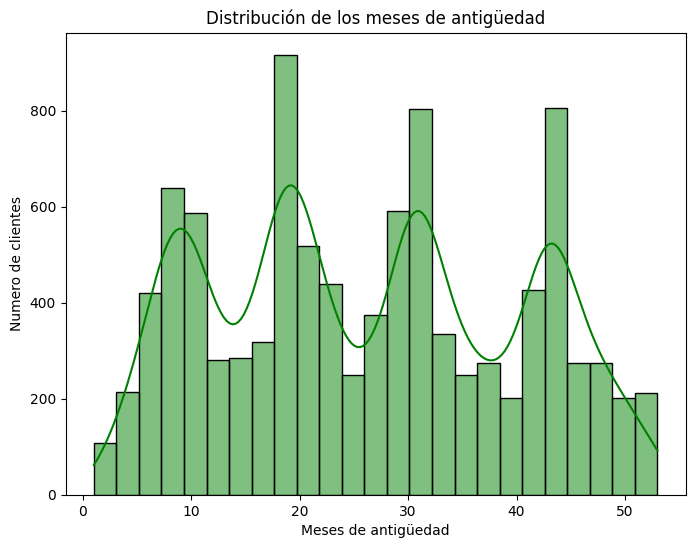

In [105]:
# Grafico meses antiguedad
plt.figure(figsize=(8, 6))
sns.histplot(data=df_joined, x='meses_antiguedad', kde=True, color='green', stat='count', palette='Spectral')
plt.title('Distribución de los meses de antigüedad')
plt.xlabel('Meses de antigüedad')
plt.ylabel('Numero de clientes')
plt.xticks(rotation=0)
plt.show()

## Probabilidad de compra

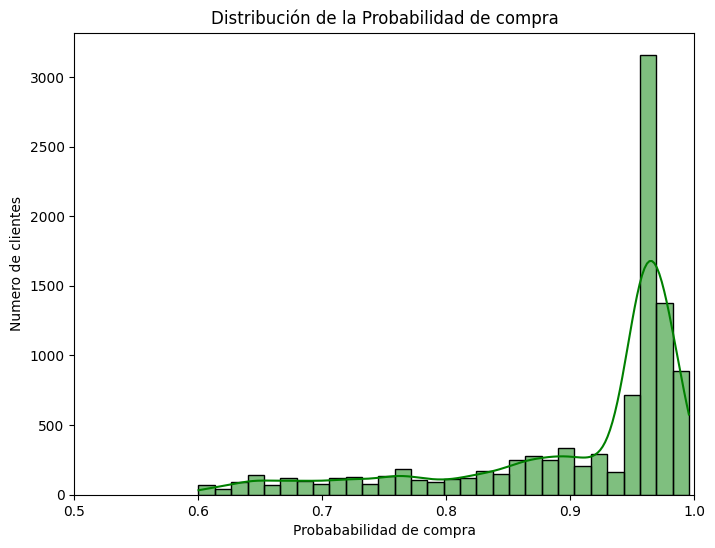

In [106]:
# Supongamos que 'variable_numerica' es el nombre de tu columna numérica que va de 0 a 1
plt.figure(figsize=(8, 6))
sns.histplot(data=df_joined, x='prob_compra', bins=30, color = "green" ,kde=True,stat='count', palette='Spectral')
plt.title('Distribución de la Probabilidad de compra')
plt.xlabel('Probababilidad de compra')
plt.ylabel('Numero de clientes')
plt.xlim(0.5, 1)
plt.xticks(rotation=0)
plt.show()

Añadir la variable prob_compra a la segmentación tiene sentido porque proporciona una estimación clara de la probabilidad de que un cliente realice una compra. Con valores que van de 0.6 a 1, esta variable nos permite identificar distintos niveles de intención de compra. Al segmentar en función de esta probabilidad, podemos personalizar los mensajes de marketing, enfocándonos en aquellos clientes más propensos a realizar una compra y diferenciando estrategias para aquellos con probabilidades más bajas, lo que optimiza la efectividad de la campaña.

## Edad

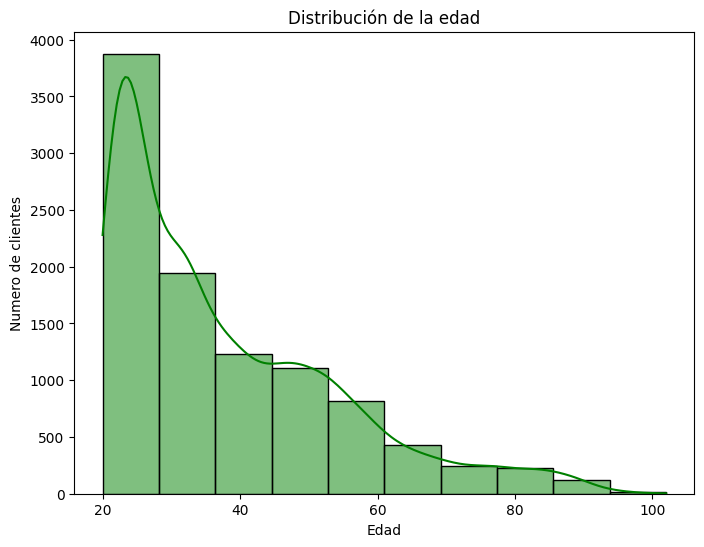

In [107]:
# Grafico edad
plt.figure(figsize=(8, 6))
sns.histplot(data=df_joined, x='age', bins=10, kde=True, color='green', stat='count', palette='Spectral')
plt.title('Distribución de la edad')
plt.xlabel('Edad')
plt.ylabel('Numero de clientes')
plt.xticks(rotation=0)
plt.show()

Añadir la variable edad a la segmentación es fundamental porque las necesidades, preferencias y comportamientos de compra suelen variar significativamente en función de la etapa de la vida en la que se encuentra un cliente. La edad influye en muchos aspectos, desde los productos o servicios que podrían interesar hasta la forma en que un cliente prefiere recibir información. Al segmentar por edad, podemos personalizar las campañas para que sean más relevantes y atractivas para cada grupo demográfico, aumentando así la efectividad de la estrategia de marketing.

Además, optar por la variable numérica en lugar de agrupar por rangos de edad permite una mayor precisión en el análisis. Esta precisión es especialmente crucial para el modelo KNN, que se basa en la distancia entre puntos de datos. Al utilizar la edad como un valor continuo, mejoramos la capacidad del modelo para identificar patrones y similitudes, lo que resulta en recomendaciones y segmentaciones más efectivas.

In [108]:
df_joined.drop('grupo_edad', axis=1, inplace=True)

## Median_salary

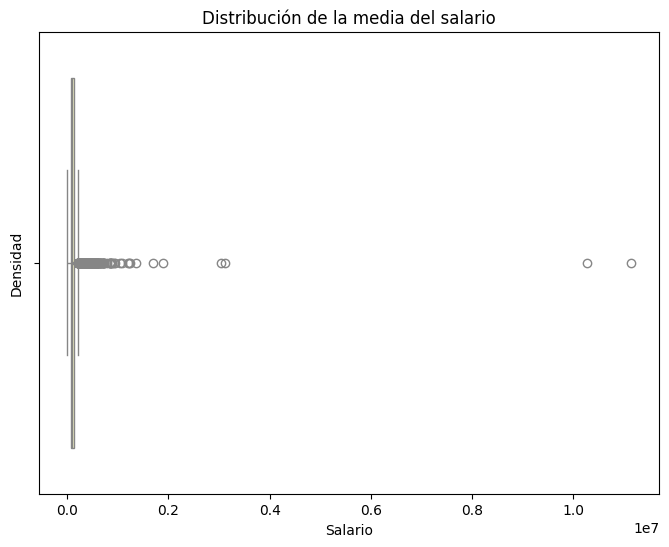

In [109]:
# Grafica salario
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_joined, x='median_salary', color='green',  palette='Spectral')
plt.title('Distribución de la media del salario')
plt.xlabel('Salario')
plt.ylabel('Densidad')
plt.xticks(rotation=0)
plt.show()

Vamos a tratar los outliers en la variable median_salary porque los valores extremadamente altos pueden distorsionar el rendimiento del modelo. Estos outliers pueden sesgar la segmentación, haciendo que el modelo se enfoque en patrones que no son representativos del comportamiento general de los clientes. Al limitar estos valores, reducimos su impacto negativo y mejoramos la capacidad del modelo para identificar grupos más consistentes y útiles para la campaña de marketing. 

In [110]:
# Calcular los percentiles 90% y 95%
percentile_90 = df_joined['median_salary'].quantile(0.90)
percentile_95 = df_joined['median_salary'].quantile(0.95)

# Imprimir los resultados
print(f"Percentil 90: {percentile_90}")
print(f"Percentil 95: {percentile_95}")

Percentil 90: 193746.768
Percentil 95: 249174.44999999995



Limitar el valor de median_salary en el percentil 95% es una técnica común para tratar outliers sin eliminar datos por completo. Al limitar el salario en el percentil 95%, mantenemos la mayoría de los datos representativos y reducimos la influencia de valores atípicos. Esta técnica permite que el modelo se concentre en la distribución típica de los salarios y mejora la capacidad de generalización en la segmentación de clientes.

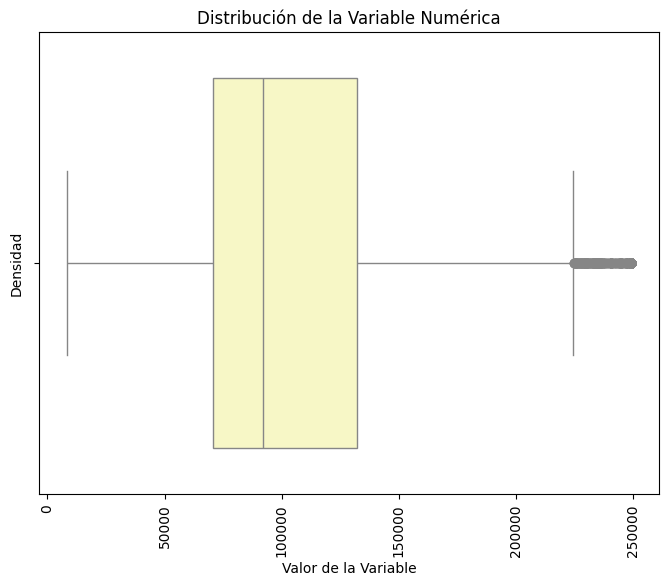

In [111]:
# Limitar el median_salary al percentil 95
df_joined['median_salary'] = df_joined['median_salary'].apply(lambda x: min(x, percentile_95))

# Supongamos que 'variable_numerica' es el nombre de tu columna numérica que va de 0 a 1
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_joined, x='median_salary', color='green',palette="Spectral")
plt.title('Distribución de la Variable Numérica')
plt.xlabel('Valor de la Variable')
plt.ylabel('Densidad')
plt.xticks(rotation=90)
plt.show()

## Productos recomendados

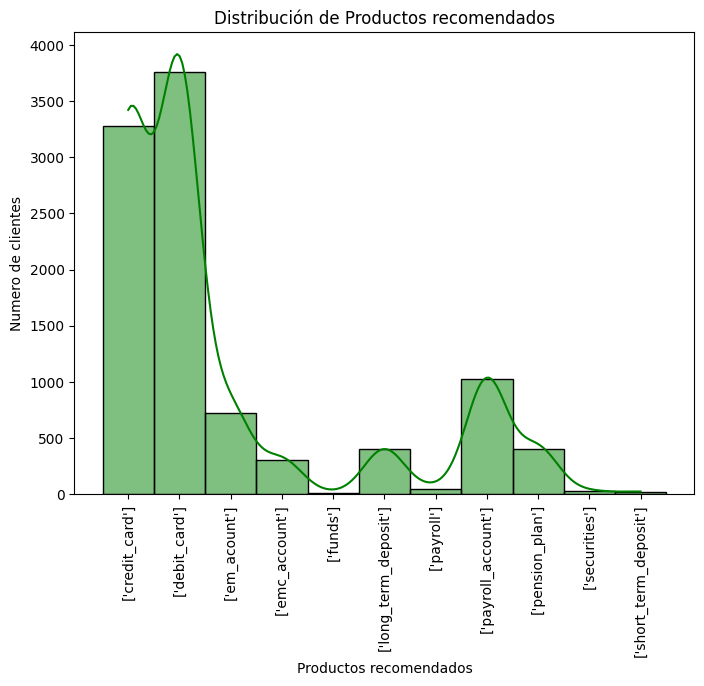

In [112]:

plt.figure(figsize=(8, 6))
sns.histplot(data=df_joined, x='recomendacion', kde=True, color='green', palette='Spectral')
plt.title('Distribución de Productos recomendados')
plt.xlabel('Productos recomendados')
plt.ylabel('Numero de clientes')
plt.xticks(rotation=90)
plt.show()


Incluir la variable del producto recomendado con más probabilidad de venta permite personalizar las ofertas, aumentando la relevancia para los clientes y maximizando la efectividad de la campaña, lo que resulta en mayores tasas de conversión y ventas.

In [113]:
df_joined

,pk_cid,recomendacion,prob_compra,precio,beneficio,cluster,num_products_contracts,country_id,gender,mes_partition,mes_nombre_partition,median_salary,region_code,entry_channel,active_customer,segment,age,meses_antiguedad
0,1119834,['credit_card'],0.987,60,59.212,4,3,ES,V,5,May,"198,675.690",Madrid,KFC,1,01 - TOP,63,40
1,88904,['credit_card'],0.987,60,59.191,4,3,ES,H,5,May,"249,174.450",Madrid,KFA,1,01 - TOP,48,46
2,1136278,['credit_card'],0.985,60,59.100,4,4,ES,V,5,May,"95,704.380",Cantabria,KAT,1,01 - TOP,53,36
3,1119669,['credit_card'],0.985,60,59.095,4,5,ES,V,5,May,"82,723.080",Madrid,KFC,1,01 - TOP,58,40
4,1109597,['credit_card'],0.985,60,59.095,4,5,ES,V,5,May,"249,174.450",Madrid,KFC,1,01 - TOP,59,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1304214,['emc_account'],0.955,10,9.553,4,5,ES,V,5,May,"62,895.900",Badajoz,RED,1,02 - PARTICULARES,37,20
9996,1393343,['payroll_account'],0.955,10,9.553,4,2,ES,V,5,May,"88,963.110",Badajoz,RED,1,02 - PARTICULARES,38,13
9997,1334243,['debit_card'],0.955,10,9.553,4,3,ES,V,5,May,"63,117.990",Badajoz,RED,1,02 - PARTICULARES,41,19
9998,1376649,['emc_account'],0.955,10,9.553,4,4,ES,V,5,May,"69,536.970",Badajoz,RED,1,02 - PARTICULARES,41,16


## Cluster

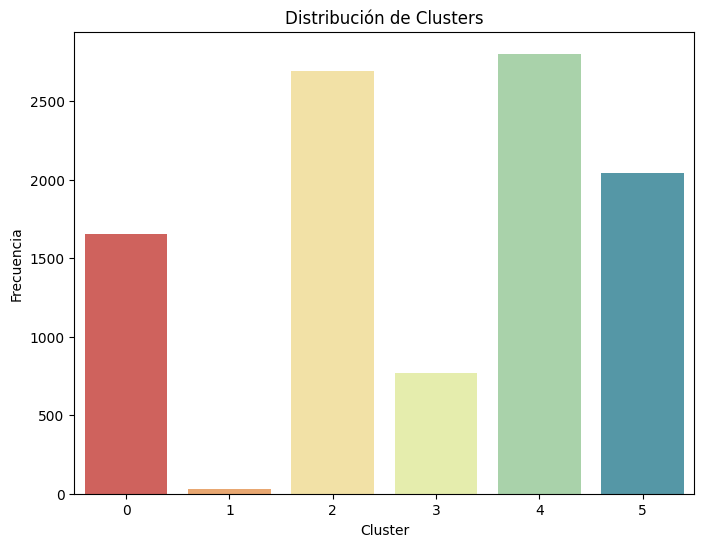

In [114]:
# Creamos el gráfico de barras utilizando seaborn
plt.figure(figsize=(8, 6))
sns.countplot(data=df_joined, x='cluster',color = "green", palette='Spectral')
plt.title('Distribución de Clusters')
plt.xlabel('Cluster')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0)
plt.show()

In [115]:
df_joined['cluster'].value_counts(normalize = True) * 100

cluster
4   28.030
2   26.960
5   20.450
0   16.570
3    7.700
1    0.290
Name: proportion, dtype: float64


Se añade la variable cluster definida en la Tarea 2 de segmentación porque proporciona una categorización clara de los clientes en grupos homogéneos, permitiendo identificar y analizar comportamientos y características comunes dentro de cada clúster. Con una distribución que abarca múltiples grupos (desde el clúster 0 hasta el 5), esta variable facilita la personalización de estrategias de marketing y la asignación de recursos de manera más efectiva. La inclusión del clúster en la segmentación permitirá desarrollar campañas más específicas y alineadas con las necesidades y preferencias de cada grupo, mejorando así la efectividad general de las acciones comerciales.

## Country_id

In [116]:
# Contar cuántas veces aparece cada valor en la columna 'country_id'
country_counts = df_joined['country_id'].value_counts()

# Mostrar los resultados
print(country_counts)

country_id
ES    9987
GB       3
CH       2
RO       1
CI       1
FR       1
CL       1
CA       1
US       1
MX       1
PE       1
Name: count, dtype: int64


Se elimina la variable country_id debido a su distribución desbalanceada, ya que la mayoría de los registros corresponden a un solo país. Esto podría sesgar los resultados y no aportar valor significativo a la segmentación, dificultando la identificación de patrones relevantes.

In [117]:
df_joined.drop('country_id', axis=1, inplace=True)

## Numero de productos contratados

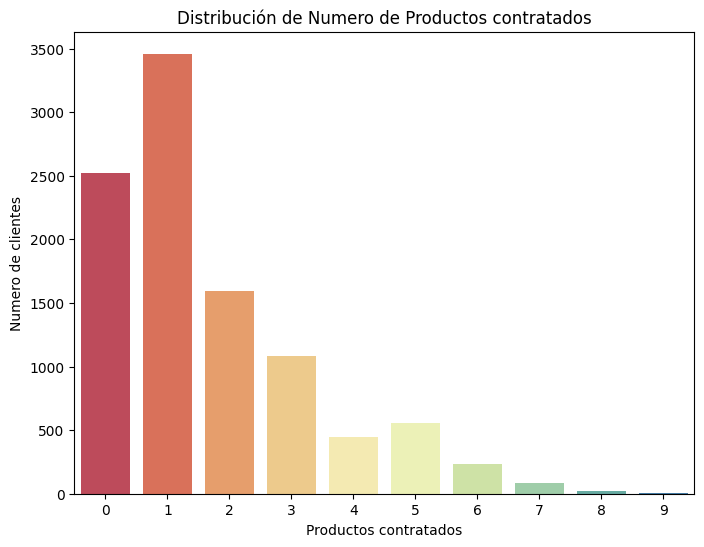

In [118]:
# Obtener los valores únicos de 'num_products_contracts'

plt.figure(figsize=(8, 6))
sns.countplot(data=df_joined, x='num_products_contracts', palette='Spectral')
plt.title('Distribución de Numero de Productos contratados')
plt.xlabel('Productos contratados')
plt.ylabel('Numero de clientes')
plt.xticks(rotation=0)
plt.show()

In [119]:
df_joined['num_products_contracts'].value_counts(normalize = True) * 100

num_products_contracts
1   34.600
0   25.240
2   15.930
3   10.830
5    5.540
4    4.480
6    2.330
7    0.840
8    0.190
9    0.020
Name: proportion, dtype: float64


Se añade la variable num_products_contracts a la segmentación debido a su capacidad para proporcionar información valiosa sobre el comportamiento de los clientes. Con una distribución que muestra una variedad de niveles de contratación (desde 0 hasta 9 productos), esta variable permite identificar patrones en la lealtad del cliente y la potencialidad de ventas adicionales. Además, la inclusión de esta variable facilita la personalización de ofertas y la segmentación de clientes en función de su compromiso con la empresa, lo que puede conducir a estrategias de marketing más efectivas y a un aumento en la retención de clientes.

## Gender

In [120]:
df_joined['gender'].value_counts(normalize = True) * 100

gender
V   59.610
H   40.390
Name: proportion, dtype: float64


Se incluye la variable gender en la segmentación debido a su distribución equilibrada, con un 59.610% de hombres (V) y un 40.390% de mujeres (H). Esta diversidad permite identificar diferencias significativas en el comportamiento y las preferencias de los clientes, lo que es fundamental para personalizar las estrategias de marketing y mejorar la efectividad de las campañas dirigidas a cada género.

## Mes_Partition

In [121]:
df_joined['mes_partition'].value_counts(normalize = True) * 100

mes_partition
5    98.970
7     0.260
4     0.160
2     0.140
3     0.100
10    0.100
12    0.080
9     0.070
1     0.060
11    0.030
8     0.030
Name: proportion, dtype: float64

Se eliminan las variables mes_partition y mes_nombre_partition debido a su distribución desbalanceada, donde una única categoría (mes 5) representa una proporción abrumadora del 98.970%. Este desequilibrio indica que la mayoría de los datos están concentrados en un solo mes, lo que limita la variabilidad y la capacidad de estas variables para contribuir a la segmentación de manera efectiva. Mantener estas variables podría introducir ruido en el análisis y no ofrecer información valiosa para identificar patrones significativos entre los clientes.

In [122]:
df_joined.drop('mes_partition', axis=1, inplace=True)
df_joined.drop('mes_nombre_partition', axis=1, inplace=True)

## Active_customer

In [123]:
df_joined['active_customer'].value_counts(normalize = True) * 100

active_customer
1   54.470
0   45.530
Name: proportion, dtype: float64

Se añade la variable active_customer a la segmentación porque proporciona una clara indicación del nivel de compromiso de los clientes con la empresa. Con una distribución casi equilibrada (54.470% de clientes activos y 45.530% de inactivos), esta variable permite identificar y analizar diferencias en el comportamiento de compra, preferencias y respuestas a las campañas de marketing entre los clientes activos e inactivos.

Incluir esta variable es fundamental para personalizar las estrategias de marketing y reactivación. Por ejemplo, se pueden diseñar campañas específicas para volver a involucrar a los clientes inactivos, mientras que las campañas dirigidas a los clientes activos pueden centrarse en la fidelización y en el aumento del valor del cliente a largo plazo. De esta manera, se maximiza el impacto de las acciones comerciales y se optimiza la retención de clientes.

In [124]:
df_joined

,pk_cid,recomendacion,prob_compra,precio,beneficio,cluster,num_products_contracts,gender,median_salary,region_code,entry_channel,active_customer,segment,age,meses_antiguedad
0,1119834,['credit_card'],0.987,60,59.212,4,3,V,"198,675.690",Madrid,KFC,1,01 - TOP,63,40
1,88904,['credit_card'],0.987,60,59.191,4,3,H,"249,174.450",Madrid,KFA,1,01 - TOP,48,46
2,1136278,['credit_card'],0.985,60,59.100,4,4,V,"95,704.380",Cantabria,KAT,1,01 - TOP,53,36
3,1119669,['credit_card'],0.985,60,59.095,4,5,V,"82,723.080",Madrid,KFC,1,01 - TOP,58,40
4,1109597,['credit_card'],0.985,60,59.095,4,5,V,"249,174.450",Madrid,KFC,1,01 - TOP,59,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1304214,['emc_account'],0.955,10,9.553,4,5,V,"62,895.900",Badajoz,RED,1,02 - PARTICULARES,37,20
9996,1393343,['payroll_account'],0.955,10,9.553,4,2,V,"88,963.110",Badajoz,RED,1,02 - PARTICULARES,38,13
9997,1334243,['debit_card'],0.955,10,9.553,4,3,V,"63,117.990",Badajoz,RED,1,02 - PARTICULARES,41,19
9998,1376649,['emc_account'],0.955,10,9.553,4,4,V,"69,536.970",Badajoz,RED,1,02 - PARTICULARES,41,16


## Segment

In [125]:
df_joined['segment'].value_counts(normalize = True) * 100 

segment
03 - UNIVERSITARIO   47.860
01 - TOP             34.530
02 - PARTICULARES    17.610
Name: proportion, dtype: float64

## Region_code

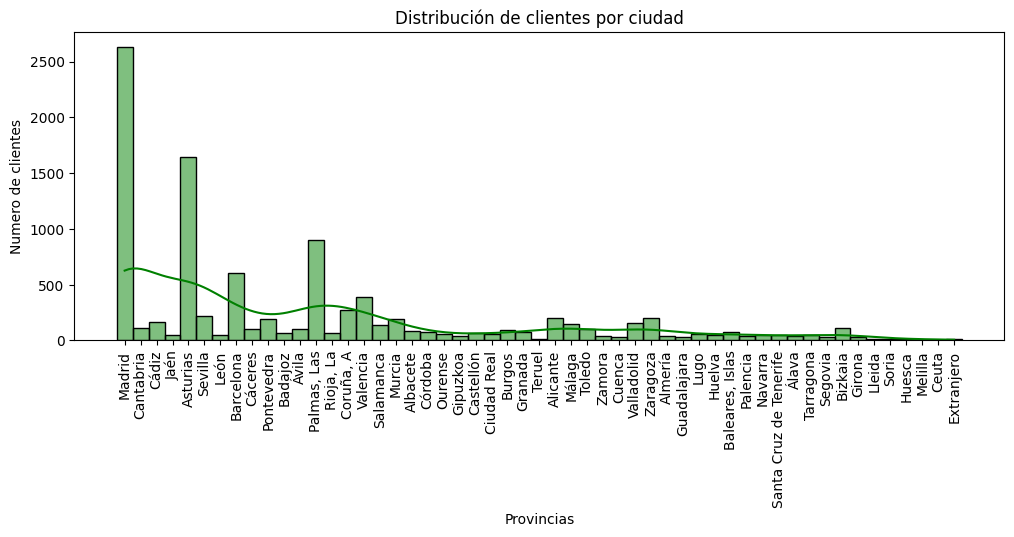

In [126]:
plt.figure(figsize=(12, 4))
sns.histplot(data=df_joined, x='region_code', kde=True, color='green', palette='Spectral')
plt.title('Distribución de clientes por ciudad')
plt.xlabel('Provincias')
plt.ylabel('Numero de clientes')
plt.xticks(rotation=90)
plt.show()

In [127]:
df_joined['segment'].value_counts(normalize = True) * 100 

segment
03 - UNIVERSITARIO   47.860
01 - TOP             34.530
02 - PARTICULARES    17.610
Name: proportion, dtype: float64

Voy a sustituir cada provincia por su número de habitantes para calcular la media de habitantes en cada cluster, lo que me brindará una idea del tamaño de las ciudades de mis clientes. Aunque no podré identificar la región específica de cada segmento, esta información me ayudará a diferenciar entre clientes de ciudades grandes y pequeñas.

Para llevar a cabo este enfoque, recogeré los datos de población del INE del año 2019 y realizaré las sustituciones necesarias.


In [128]:

# Población total de España
poblacion_total = 47026208

# Calcular la media de población por provincia
media_poblacion = poblacion_total / 52

# Diccionario que relaciona las provincias con su población
poblacion_dict = {
    'Madrid': 6663394,
    'Asturias': 1022800,
    'Palmas, Las': 1120406,
    'Barcelona': 5664579,
    'Valencia': 2565124,
    'Coruña, A': 1119596,
    'Sevilla': 1942389,
    'Alicante': 1858683,
    'Zaragoza': 964693,
    'Pontevedra': 942665,
    'Murcia': 1493898,
    'Cádiz': 1240155,
    'Valladolid': 519546,
    'Málaga': 1661785,
    'Salamanca': 330119,
    'Cantabria': 581078,
    'Bizkaia': 1152651,
    'Ávila': 157640,
    'Cáceres': 394151,
    'Toledo': 694844,
    'Burgos': 356958,
    'Albacete': 388167,
    'Baleares, Islas': 1149460,
    'Córdoba': 782979,
    'Granada': 914678,
    'Rioja, La': 316798,
    'Badajoz': 673559,
    'Castellón': 579962,
    'Lugo': 329587,
    'Ciudad Real': 495761,
    'Ourense': 307651,
    'León': 460001,
    'Huelva': 521870,
    'Jaén': 633564,
    'Tarragona': 804664,
    'Santa Cruz de Tenerife': 1032983,
    'Navarra': 654214,
    'Zamora': 172539,
    'Álava': 331549,
    'Almería': 716820,
    'Gipuzkoa': 723576,
    'Palencia': 160980,
    'Guadalajara': 257762,
    'Segovia': 153129,
    'Girona': 771044,
    'Cuenca': 196329,
    'Huesca': 220461,
    'Lleida': 434930,
    'Extranjero': media_poblacion,  # Media de la población para "Extranjero"
    'Soria': 88636,
    'Teruel': 134137,
    'Melilla': 86487,
    'Ceuta': 84777
}

# Reemplazar los nombres de provincias en df_joined por la población correspondiente
df_joined['region_code'] = df_joined['region_code'].replace(poblacion_dict)

# Cambiar el tipo de la columna a int
df_joined['region_code'] = df_joined['region_code'].astype(int)

# Verifica los cambios
df_joined

,pk_cid,recomendacion,prob_compra,precio,beneficio,cluster,num_products_contracts,gender,median_salary,region_code,entry_channel,active_customer,segment,age,meses_antiguedad
0,1119834,['credit_card'],0.987,60,59.212,4,3,V,"198,675.690",6663394,KFC,1,01 - TOP,63,40
1,88904,['credit_card'],0.987,60,59.191,4,3,H,"249,174.450",6663394,KFA,1,01 - TOP,48,46
2,1136278,['credit_card'],0.985,60,59.100,4,4,V,"95,704.380",581078,KAT,1,01 - TOP,53,36
3,1119669,['credit_card'],0.985,60,59.095,4,5,V,"82,723.080",6663394,KFC,1,01 - TOP,58,40
4,1109597,['credit_card'],0.985,60,59.095,4,5,V,"249,174.450",6663394,KFC,1,01 - TOP,59,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1304214,['emc_account'],0.955,10,9.553,4,5,V,"62,895.900",673559,RED,1,02 - PARTICULARES,37,20
9996,1393343,['payroll_account'],0.955,10,9.553,4,2,V,"88,963.110",673559,RED,1,02 - PARTICULARES,38,13
9997,1334243,['debit_card'],0.955,10,9.553,4,3,V,"63,117.990",673559,RED,1,02 - PARTICULARES,41,19
9998,1376649,['emc_account'],0.955,10,9.553,4,4,V,"69,536.970",673559,RED,1,02 - PARTICULARES,41,16


In [129]:
# Cambiar el nombre de la columna
df_joined.rename(columns={'region_code': 'pob_provincia'}, inplace=True)

La columna entry_channel se eliminará del DataFrame debido a la falta de información sobre su significado y contexto. Sin una comprensión clara de lo que representa, es difícil evaluar su relevancia y utilidad en el análisis

In [130]:
df_joined.drop('entry_channel', axis=1, inplace=True)

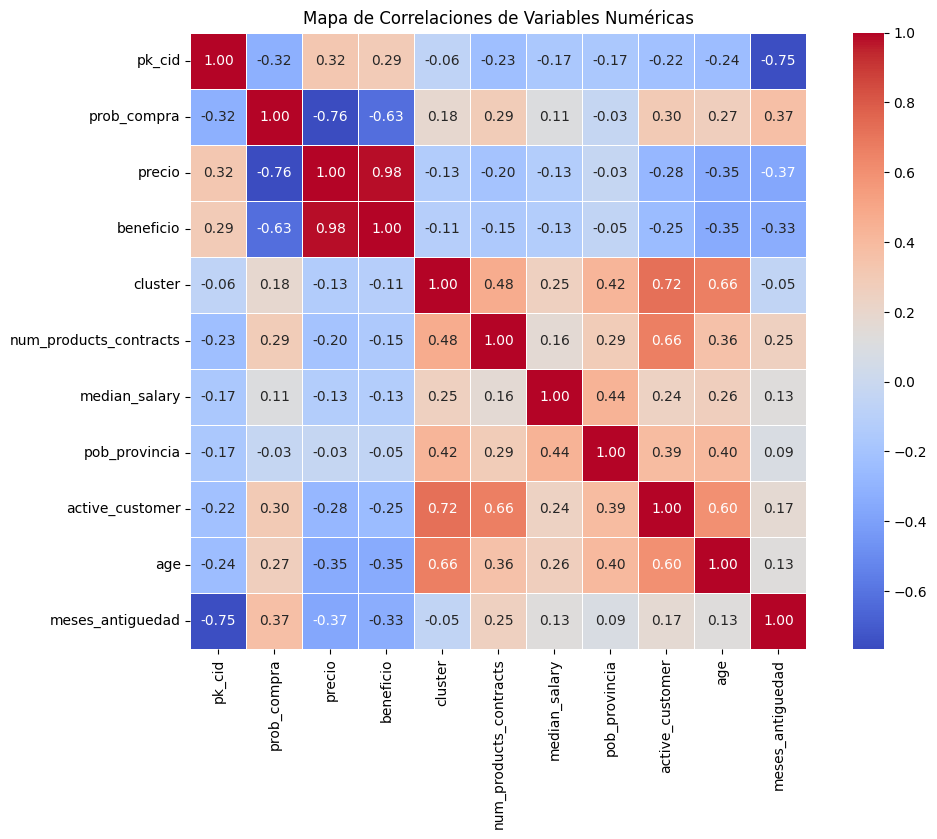

In [131]:
# Convertir columnas int32 a int64
for col in df_joined.select_dtypes(include=['int32']).columns:
    df_joined[col] = df_joined[col].astype('int64')

# Convertir columnas float32 a float64
for col in df_joined.select_dtypes(include=['float32']).columns:
    df_joined[col] = df_joined[col].astype('float64')

# Filtrar solo las columnas numéricas
numerical_df = df_joined.select_dtypes(include=['float64', 'int64'])

# Calculamos la matriz de correlación
correlation_matrix = numerical_df.corr()

# Configuramos el tamaño del gráfico
plt.figure(figsize=(12, 8))

# Creamos el mapa de calor
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True, linewidths=0.5)

# Título del gráfico
plt.title('Mapa de Correlaciones de Variables Numéricas')

# Mostramos el gráfico
plt.show()

Se ha decidido eliminar la variable precio debido a su alta correlación con beneficio, que es más informativa ya que combina el precio del producto con la probabilidad de compra.

In [132]:
df_joined.drop('precio', axis=1, inplace=True)

# Encoding

In [133]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   pk_cid                  10000 non-null  int64   
 1   recomendacion           10000 non-null  category
 2   prob_compra             10000 non-null  float64 
 3   beneficio               10000 non-null  float64 
 4   cluster                 10000 non-null  int64   
 5   num_products_contracts  10000 non-null  int64   
 6   gender                  10000 non-null  object  
 7   median_salary           10000 non-null  float64 
 8   pob_provincia           10000 non-null  int64   
 9   active_customer         10000 non-null  int64   
 10  segment                 10000 non-null  category
 11  age                     10000 non-null  int64   
 12  meses_antiguedad        10000 non-null  int64   
dtypes: category(2), float64(3), int64(7), object(1)
memory usage: 879.5+ KB


In [134]:
# Cambiar 'gender' a 1 si es 'V' y 0 si es 'H'
df_joined['genero_v'] = df_joined['gender'].map({'V': 1, 'H': 0})

# Eliminar la columna original 'gender'
df_joined.drop(columns=['gender'], inplace=True)

In [135]:
# Eliminar la columna original 'prob_compra'
df_joined.drop(columns=['prob_compra'], inplace=True)

In [136]:
# Eliminar la columna original 'cluster'
df_joined.drop(columns=['cluster'], inplace=True)

In [137]:
# Eliminar la columna original 'recomendacion'
df_joined.drop(columns=['recomendacion'], inplace=True)

In [138]:
# Eliminar la columna original 'active_customer'
df_joined.drop(columns=['active_customer'], inplace=True)

In [145]:
# Eliminar la columna original 'active_customer'
df_joined.drop(columns=['segment'], inplace=True)

In [146]:
df_joined

,beneficio,num_products_contracts,median_salary,pob_provincia,age,meses_antiguedad,genero_v
pk_cid,,,,,,,
1119834,59.212,3,198676,6663394,63,40,1
88904,59.191,3,249174,6663394,48,46,0
1136278,59.100,4,95704,581078,53,36,1
1119669,59.095,5,82723,6663394,58,40,1
1109597,59.095,5,249174,6663394,59,42,1
...,...,...,...,...,...,...,...
1304214,9.553,5,62896,673559,37,20,1
1393343,9.553,2,88963,673559,38,13,1
1334243,9.553,3,63118,673559,41,19,1


In [147]:
# Redondear los valores de median_salary y cambiar a tipo int64
df_joined['median_salary'] = df_joined['median_salary'].round().astype('int64')

In [148]:
df_joined

,beneficio,num_products_contracts,median_salary,pob_provincia,age,meses_antiguedad,genero_v
pk_cid,,,,,,,
1119834,59.212,3,198676,6663394,63,40,1
88904,59.191,3,249174,6663394,48,46,0
1136278,59.100,4,95704,581078,53,36,1
1119669,59.095,5,82723,6663394,58,40,1
1109597,59.095,5,249174,6663394,59,42,1
...,...,...,...,...,...,...,...
1304214,9.553,5,62896,673559,37,20,1
1393343,9.553,2,88963,673559,38,13,1
1334243,9.553,3,63118,673559,41,19,1


In [149]:
# Establecer la columna pk_cid como índice
df_joined.set_index('pk_cid', inplace=True)

KeyError: "None of ['pk_cid'] are in the columns"

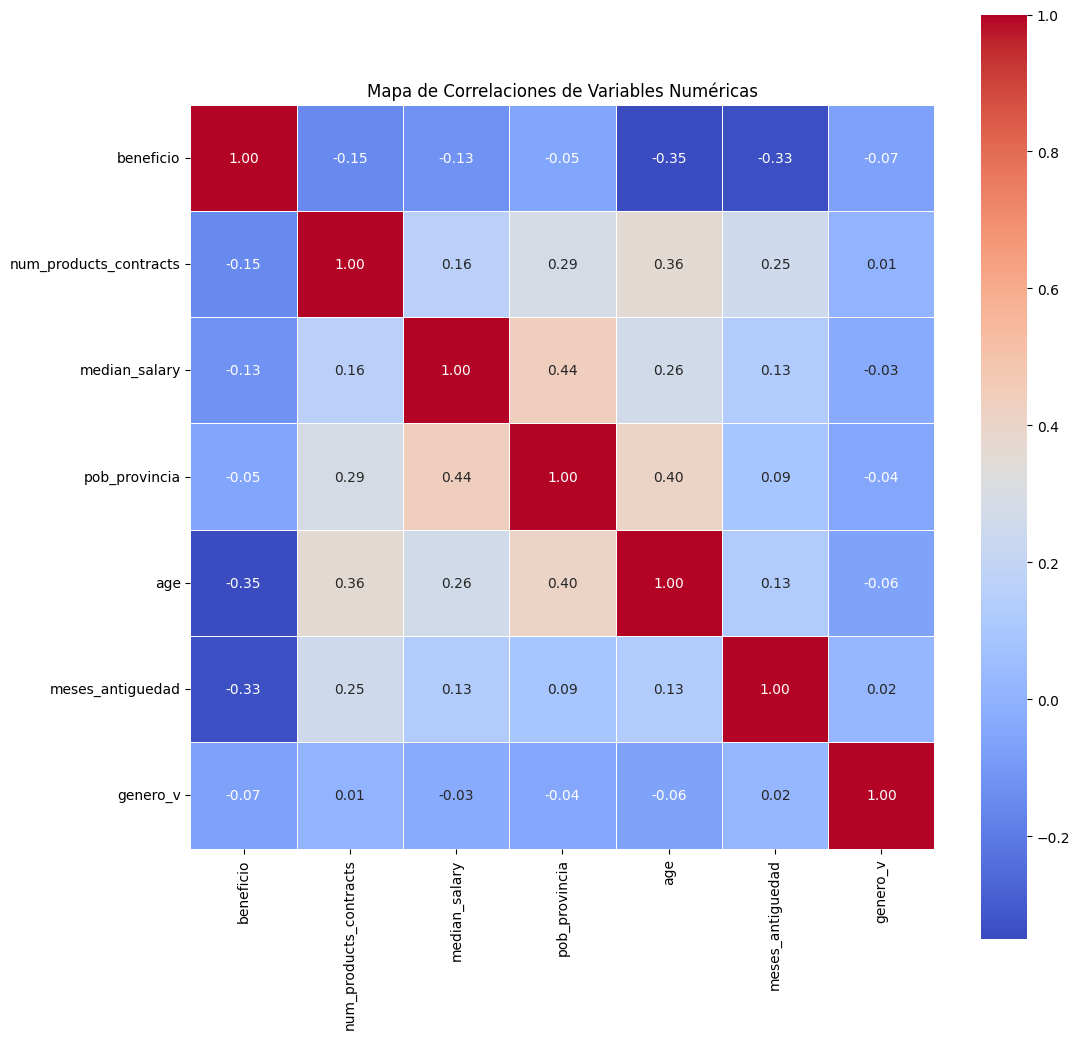

In [150]:
# Calculamos la matriz de correlación
correlation_matrix = df_joined.corr()

# Configuramos el tamaño del gráfico
plt.figure(figsize=(12, 12))

# Creamos el mapa de calor
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True, linewidths=0.5)

# Título del gráfico
plt.title('Mapa de Correlaciones de Variables Numéricas')

# Mostramos el gráfico
plt.show()

In [151]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1119834 to 1372741
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   beneficio               10000 non-null  float64
 1   num_products_contracts  10000 non-null  int64  
 2   median_salary           10000 non-null  int64  
 3   pob_provincia           10000 non-null  int64  
 4   age                     10000 non-null  int64  
 5   meses_antiguedad        10000 non-null  int64  
 6   genero_v                10000 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 625.0 KB


In [152]:
# Crear el escalador
scaler = RobustScaler()

# Aplicar el escalador a las columnas numéricas
df_joined_scaled = df_joined.copy()
df_joined_scaled[df_joined_scaled.columns] = scaler.fit_transform(df_joined_scaled)

# Mostrar el DataFrame escalado
df_joined_scaled

,beneficio,num_products_contracts,median_salary,pob_provincia,age,meses_antiguedad,genero_v
pk_cid,,,,,,,
1119834,1.474,1.000,1.729,0.983,1.250,0.609,0.000
88904,1.473,1.000,2.548,0.983,0.625,0.870,-1.000
1136278,1.471,1.500,0.059,-0.096,0.833,0.435,0.000
1119669,1.471,2.000,-0.151,0.983,1.042,0.609,0.000
1109597,1.471,2.000,2.548,0.983,1.083,0.696,0.000
...,...,...,...,...,...,...,...
1304214,-0.008,2.000,-0.473,-0.079,0.167,-0.261,0.000
1393343,-0.008,0.500,-0.050,-0.079,0.208,-0.565,0.000
1334243,-0.008,1.000,-0.469,-0.079,0.333,-0.304,0.000


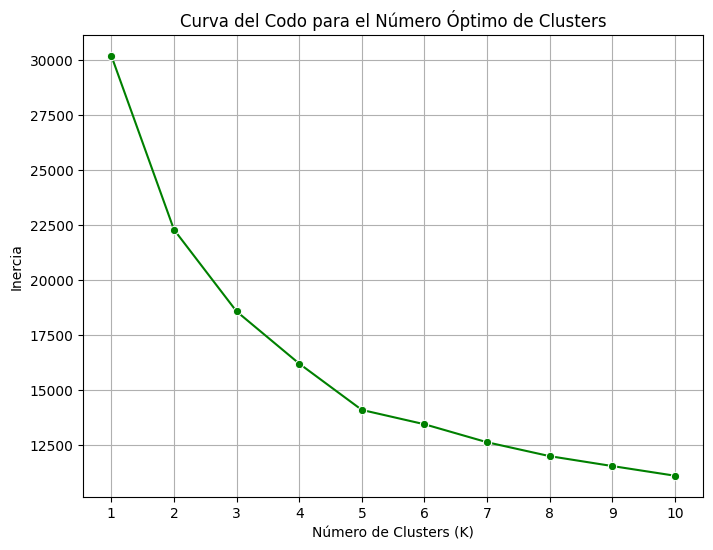

In [153]:
# Definir el rango de clusters a evaluar
range_n_clusters = range(1, 11)
inertia = []

# Calcular la inercia para cada número de clusters
for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_joined_scaled)
    inertia.append(kmeans.inertia_)

# Dibujar la curva del codo
plt.figure(figsize=(8, 6))
sns.lineplot(x=range_n_clusters, y=inertia, marker='o',color = 'green',palette='Spectral')
plt.title('Curva del Codo para el Número Óptimo de Clusters')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inercia')
plt.xticks(range_n_clusters)
plt.grid()
plt.show()

In [154]:
cluster_model_4 = KMeans(n_clusters = 4, random_state=42)
cluster_model_5 = KMeans(n_clusters = 5, random_state=42)


df_joined_scaled['cluster_4'] = cluster_model_4.fit_predict(df_joined_scaled)
df_joined_scaled['cluster_5'] = cluster_model_5.fit_predict(df_joined_scaled)


print(df_joined_scaled['cluster_4'].value_counts())
print(df_joined_scaled['cluster_5'].value_counts())


cluster_4
1    3190
2    2578
0    2364
3    1868
Name: count, dtype: int64
cluster_5
4    3116
0    2578
3    1868
1    1240
2    1198
Name: count, dtype: int64


In [155]:

df_joined_scaled_4 = df_joined_scaled.drop('cluster_5', axis=1)

In [156]:
df_joined_scaled_5 = df_joined_scaled.drop('cluster_4', axis=1)

In [157]:
df_joined_scaled_4


,beneficio,num_products_contracts,median_salary,pob_provincia,age,meses_antiguedad,genero_v,cluster_4
pk_cid,,,,,,,,
1119834,1.474,1.000,1.729,0.983,1.250,0.609,0.000,3
88904,1.473,1.000,2.548,0.983,0.625,0.870,-1.000,3
1136278,1.471,1.500,0.059,-0.096,0.833,0.435,0.000,0
1119669,1.471,2.000,-0.151,0.983,1.042,0.609,0.000,0
1109597,1.471,2.000,2.548,0.983,1.083,0.696,0.000,3
...,...,...,...,...,...,...,...,...
1304214,-0.008,2.000,-0.473,-0.079,0.167,-0.261,0.000,0
1393343,-0.008,0.500,-0.050,-0.079,0.208,-0.565,0.000,1
1334243,-0.008,1.000,-0.469,-0.079,0.333,-0.304,0.000,0


In [158]:
df_joined_scaled_5

,beneficio,num_products_contracts,median_salary,pob_provincia,age,meses_antiguedad,genero_v,cluster_5
pk_cid,,,,,,,,
1119834,1.474,1.000,1.729,0.983,1.250,0.609,0.000,3
88904,1.473,1.000,2.548,0.983,0.625,0.870,-1.000,3
1136278,1.471,1.500,0.059,-0.096,0.833,0.435,0.000,2
1119669,1.471,2.000,-0.151,0.983,1.042,0.609,0.000,2
1109597,1.471,2.000,2.548,0.983,1.083,0.696,0.000,3
...,...,...,...,...,...,...,...,...
1304214,-0.008,2.000,-0.473,-0.079,0.167,-0.261,0.000,2
1393343,-0.008,0.500,-0.050,-0.079,0.208,-0.565,0.000,4
1334243,-0.008,1.000,-0.469,-0.079,0.333,-0.304,0.000,1


In [159]:
cols = list(df_joined_scaled_5.columns)
cols.remove("cluster_5")
# Calcular las medias para cada cluster
pt = pd.pivot_table(df_joined_scaled_5, index='cluster_5', values=cols, aggfunc='mean')

# Calcular la cantidad de elementos en cada cluster
add = pd.pivot_table(df_joined_scaled_5, index='cluster_5', values='num_products_contracts', aggfunc='count')
pt['count'] = add

# Añadir 'count' a la lista de columnas para la visualización final
cols.append('count')

# Mostrar la tabla con estilos y gradientes de color
pt[cols].style.background_gradient(cmap='coolwarm')

,beneficio,num_products_contracts,median_salary,pob_provincia,age,meses_antiguedad,genero_v,count
cluster_5,,,,,,,,
0,1.126180,-0.414275,-0.078225,0.183581,-0.207331,-0.404071,-0.440652,2578
1,0.085180,0.738710,0.001603,0.452720,1.182762,0.053366,-0.411290,1240
2,0.735411,1.899833,0.042713,0.415355,0.214072,0.166255,-0.413189,1198
3,0.216278,0.532923,1.726204,0.718705,0.692764,0.186435,-0.441649,1868
4,0.034197,0.060013,-0.133016,0.037209,-0.149698,0.169741,-0.344352,3116


In [160]:
cols = list(df_joined_scaled_4.columns)
cols.remove("cluster_4")
# Calcular las medias para cada cluster
pt = pd.pivot_table(df_joined_scaled_4, index='cluster_4', values=cols, aggfunc='mean')

# Calcular la cantidad de elementos en cada cluster
add = pd.pivot_table(df_joined_scaled_4, index='cluster_4', values='num_products_contracts', aggfunc='count')
pt['count'] = add

# Añadir 'count' a la lista de columnas para la visualización final
cols.append('count')

# Mostrar la tabla con estilos y gradientes de color
pt[cols].style.background_gradient(cmap='coolwarm')

,beneficio,num_products_contracts,median_salary,pob_provincia,age,meses_antiguedad,genero_v,count
cluster_4,,,,,,,,
0,0.417142,1.350677,0.026269,0.437619,0.690126,0.111969,-0.410321,2364
1,0.033567,0.058307,-0.132734,0.044006,-0.117503,0.166008,-0.347335,3190
2,1.126180,-0.414275,-0.078225,0.183581,-0.207331,-0.404071,-0.440652,2578
3,0.216278,0.532923,1.726204,0.718705,0.692764,0.186435,-0.441649,1868


In [161]:
df_joined_scaled_5

,beneficio,num_products_contracts,median_salary,pob_provincia,age,meses_antiguedad,genero_v,cluster_5
pk_cid,,,,,,,,
1119834,1.474,1.000,1.729,0.983,1.250,0.609,0.000,3
88904,1.473,1.000,2.548,0.983,0.625,0.870,-1.000,3
1136278,1.471,1.500,0.059,-0.096,0.833,0.435,0.000,2
1119669,1.471,2.000,-0.151,0.983,1.042,0.609,0.000,2
1109597,1.471,2.000,2.548,0.983,1.083,0.696,0.000,3
...,...,...,...,...,...,...,...,...
1304214,-0.008,2.000,-0.473,-0.079,0.167,-0.261,0.000,2
1393343,-0.008,0.500,-0.050,-0.079,0.208,-0.565,0.000,4
1334243,-0.008,1.000,-0.469,-0.079,0.333,-0.304,0.000,1


In [162]:
# Guardar la columna de clusters
clusters_5 = df_joined_scaled_5['cluster_5']

# Eliminar el resto de las columnas escaladas
df_joined_scaled_5.drop(columns=df_joined_scaled_5.columns, inplace=True)

# Revertir a los datos originales (sin escalar), salvo por la columna de clusters
df_joined_scaled_5 = df_joined.copy()

# Añadir la columna de clusters al DataFrame original
df_joined_scaled_5['cluster_5'] = clusters_5

In [164]:
df_joined_scaled_5

,beneficio,num_products_contracts,median_salary,pob_provincia,age,meses_antiguedad,genero_v,cluster_5
pk_cid,,,,,,,,
1119834,59.212,3,198676,6663394,63,40,1,3
88904,59.191,3,249174,6663394,48,46,0,3
1136278,59.100,4,95704,581078,53,36,1,2
1119669,59.095,5,82723,6663394,58,40,1,2
1109597,59.095,5,249174,6663394,59,42,1,3
...,...,...,...,...,...,...,...,...
1304214,9.553,5,62896,673559,37,20,1,2
1393343,9.553,2,88963,673559,38,13,1,4
1334243,9.553,3,63118,673559,41,19,1,1


In [165]:
# Calcular las medias de todas las columnas agrupadas por el cluster
cluster_means = df_joined_scaled_5.groupby('cluster_5').mean()

# Mostrar las medias
cluster_means

,beneficio,num_products_contracts,median_salary,pob_provincia,age,meses_antiguedad,genero_v
cluster_5,,,,,,,
0,47.558,0.171,"87,214.557","2,155,910.014",28.024,16.706,0.559
1,12.677,2.477,"92,136.863","3,674,016.533",61.386,27.227,0.589
2,34.464,4.800,"94,671.753","3,463,252.387",38.138,29.824,0.587
3,17.070,2.066,"198,478.327","5,174,331.275",49.626,30.288,0.558
4,10.969,1.120,"83,836.036","1,330,285.684",29.407,29.904,0.656


In [166]:
# Guardar la columna de clusters
clusters_4 = df_joined_scaled_4['cluster_4']

# Eliminar el resto de las columnas escaladas
df_joined_scaled_4.drop(columns=df_joined_scaled_4.columns, inplace=True)

# Revertir a los datos originales (sin escalar), salvo por la columna de clusters
df_joined_scaled_4 = df_joined.copy()

# Añadir la columna de clusters al DataFrame original
df_joined_scaled_4['cluster_4'] = clusters_4

In [167]:
# Calcular las medias de todas las columnas agrupadas por el cluster
cluster_means = df_joined_scaled_4.groupby('cluster_4').mean()

# Mostrar las medias
cluster_means

,beneficio,num_products_contracts,median_salary,pob_provincia,age,meses_antiguedad,genero_v
cluster_4,,,,,,,
0,23.800,3.701,"93,657.810","3,588,838.645",49.563,28.575,0.590
1,10.948,1.117,"83,853.447","1,368,624.607",30.180,29.818,0.653
2,47.558,0.171,"87,214.557","2,155,910.014",28.024,16.706,0.559
3,17.070,2.066,"198,478.327","5,174,331.275",49.626,30.288,0.558
